In [1]:
import datetime

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import filtfilt, butter
from scipy import signal

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

# Control maximum number of rows Pandas can show.
pd.set_option('display.max_rows', 100)

# Load Data File and Plot Raw Data

In [3]:
# Load file into dataframe, ignore comment line,s and parse dates
fname = '2021-04-07T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv.bz2'
cfreq = 10e6
df    = pd.read_csv(fname, comment = '#', parse_dates=[0])

In [4]:
df

,UTC,Freq,Vpk
0,2021-04-07 00:00:00+00:00,9999999.695,0.048158
1,2021-04-07 00:00:01+00:00,9999999.699,0.047857
2,2021-04-07 00:00:02+00:00,9999999.702,0.050586
3,2021-04-07 00:00:03+00:00,9999999.708,0.051483
4,2021-04-07 00:00:04+00:00,9999999.706,0.051156
...,...,...,...
84367,2021-04-07 23:59:54+00:00,9999999.709,0.040265
84368,2021-04-07 23:59:56+00:00,9999999.684,0.035974
84369,2021-04-07 23:59:57+00:00,9999999.678,0.035156
84370,2021-04-07 23:59:58+00:00,9999999.708,0.045633


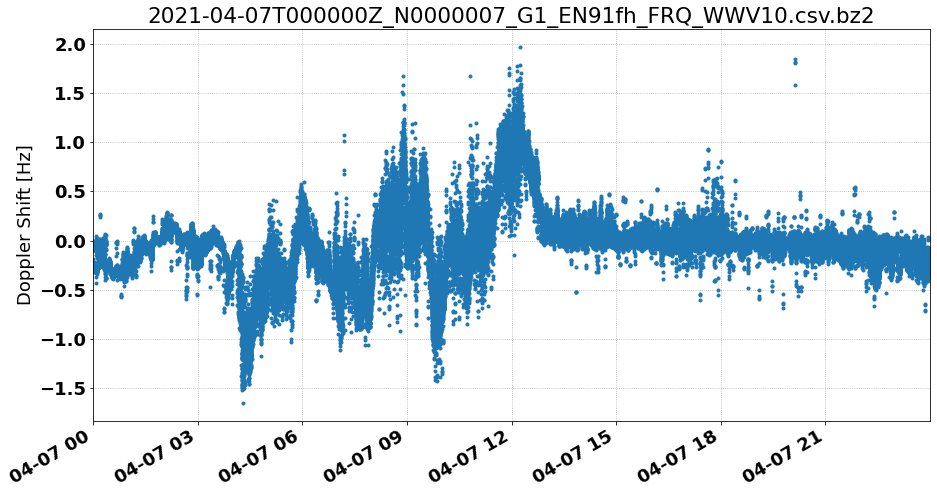

In [5]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = df['UTC']
yy  = df['Freq']-cfreq
ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Doppler Shift [Hz]')
ax.set_title(fname)
plt.show()

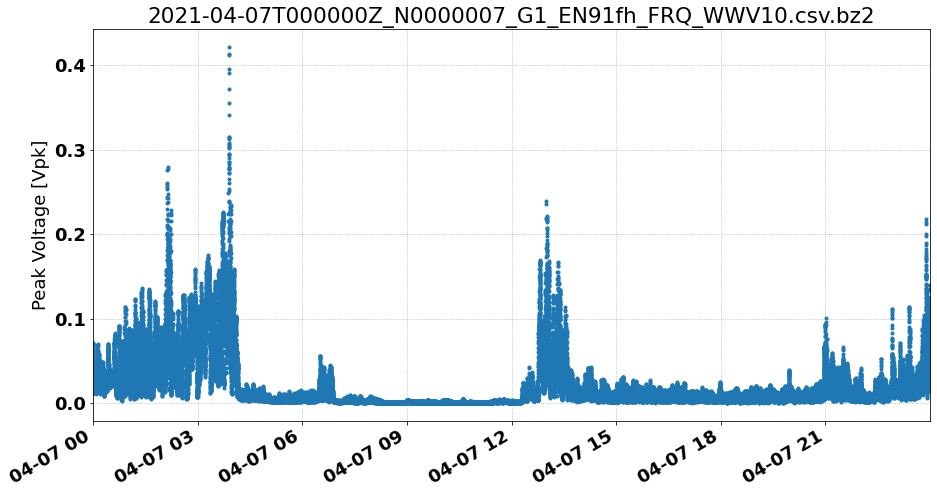

In [6]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = df['UTC']
yy  = df['Vpk']
ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Peak Voltage [Vpk]')
ax.set_title(fname)
plt.show()

# Show Data is Not Regularly Sampled

In [7]:
# Calculate time difference between samples
dt = np.diff(df['UTC'])

# Convert from time delta to total seconds
dt_sec = [x.total_seconds() for x in dt]

In [8]:
# What are the time differences between data points?
# It should only be 1 since the Grape takes 1 measurement every second.
# But, it's not.
unq = np.unique(dt_sec)
unq

array([0., 1., 2., 3.])

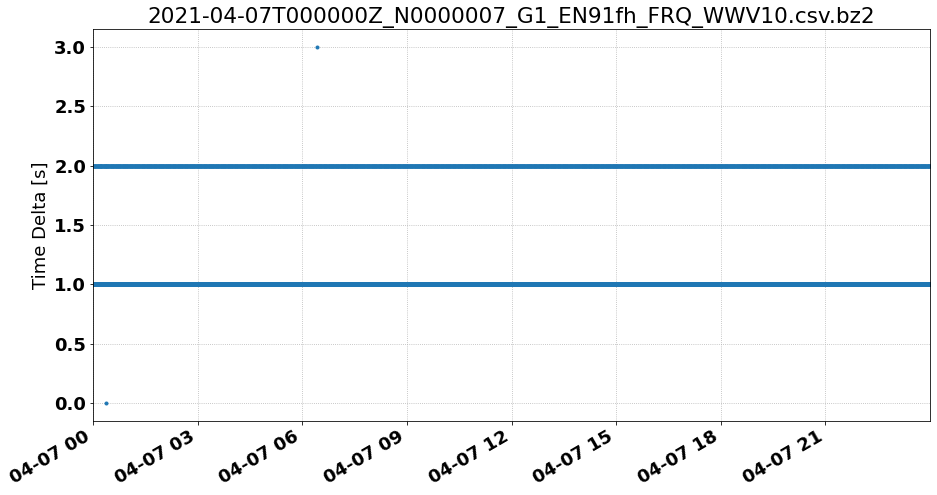

In [9]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

# np.diff() returns 1 less value than original vector,
# so we need to trim 1 element off of the original vector when plotting
xx  = df['UTC'][:-1]
yy  = dt_sec

ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Time Delta [s]')
ax.set_title(fname)
plt.show()

# Resample/Interpolate Data to Guarantee Regular Spacing

In [10]:
# Get Julian Dates for Data Frame
jd   = [x.to_julian_date() for x in df['UTC']]

In [11]:
# Create the list of datetimes that we want to resample to.

# Find the start and end times of the array.
sTime = df['UTC'].min()
eTime = df['UTC'].max()

# Break
sYr  = sTime.year
sMon = sTime.month
sDy  = sTime.day
sHr  = sTime.hour
sMin = sTime.minute
sSec = sTime.second
resample_sTime = datetime.datetime(sYr,sMon,sDy,sHr,sMin,sSec)

eYr  = eTime.year
eMon = eTime.month
eDy  = eTime.day
eHr  = eTime.hour
eMin = eTime.minute
eSec = eTime.second
resample_eTime = datetime.datetime(eYr,eMon,eDy,eHr,eMin,eSec)

dt = datetime.timedelta(seconds=1)
rs_times = [resample_sTime]
while rs_times[-1] < resample_eTime:
    rs_times.append(rs_times[-1]+dt)

# Convert to Julian Date
rs_jd   = [x.to_julian_date() for x in pd.to_datetime(rs_times)]

In [12]:
fn      = interp1d(jd,df['Freq'].values)
rs_Freq = fn(rs_jd)
rs_df   = pd.DataFrame({'UTC':rs_times,'Freq':rs_Freq})

In [13]:
rs_df

,UTC,Freq
0,2021-04-07 00:00:00,1.000000e+07
1,2021-04-07 00:00:01,1.000000e+07
2,2021-04-07 00:00:02,1.000000e+07
3,2021-04-07 00:00:03,1.000000e+07
4,2021-04-07 00:00:04,1.000000e+07
...,...,...
86395,2021-04-07 23:59:55,1.000000e+07
86396,2021-04-07 23:59:56,1.000000e+07
86397,2021-04-07 23:59:57,1.000000e+07
86398,2021-04-07 23:59:58,1.000000e+07
